# Exploring Box-Counting Dimension as Catalytic Performance Indicator of Metal Nanoparticles

This notebook contains the results from the attempt to explore the potential usefulness of the box-counting dimensions, $D_B$, of metal nanoparticles as a catalytic performance indicator. The $D_B$ values are computed using [Sphractal](https://github.com/jon-ting/sphractal), a Python package for the estimation of the fractal dimension of the surfaces of computational atomistic objects (where the atomic coordinates are known precisely) via box-counting approaches.

## Outline

[Notebook Setups](#setup)

[Relating Box-Counting Dimension with Catalytic Activity](#catact)

<a id='setup'></a>
## Notebook Setups

In [1]:
# Import relevant libraries
from os import listdir
import pickle
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sphractal

from natsort import natsorted
from sphractal import readInp, findNN

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  sphractal: {sphractal.__version__}")

Versions of imported libraries:
  matplotlib: 3.7.2
  numpy: 1.24.4
  pandas: 2.2.0
  seaborn: 0.12.2
  sphractal: 0.22.2


Below are some general settings for plotting figures:

In [2]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, dpi, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

And some handy general functions:

In [3]:
def readPickle(picklePath):
    with open(picklePath, 'rb') as f: 
        df = pickle.load(f)
    df['rangeLenVX'] = df.apply(lambda f: f['maxLenVX'] - f['minLenVX'], axis=1)
    df['rangeLenEX'] = df.apply(lambda f: f['maxLenEX'] - f['minLenEX'], axis=1)
    return df

<a id='catact'></a>
## Relating Box-Counting Dimension with Catalytic Activity

We aim to explore the connection between the known catalytic activity exhibited by nanoparticles enclosed by certain surface facets, and their fractal dimensions as estimated by $D_B$, which quantify the roughness of their atomistic surfaces.

### Data Set

The data used here are obtained from collections of atomic coordinates of simulated palladium nanoparticles generated for machine learning studies. The shapes of the nanoparticles are chosen to cover the low-index surface facets that usually dominate metal nanoparticles under reaction conditions, namely cube (`CU`), rhombic dodecahedron (`RD`), and octahedron (`OT`). 

### Identifying Suitable Nanoparticle Sizes

To minimise the impact of corners and edges of the nanoparticles on their $D_B$ values, we need to first determine the nanoparticle size when the influences of the corners and edges become negligible. Here we examine the change in the proportion of each surface atom type as the size of the nanoparticles of different shapes increases. 

First, we generate a set of atomic coordinates of simulated palladium nanoparticles of different sizes (ranging from 3-100 nm) with three particular shapes:
- cube (`CU`), enclosed by `{100}` facets, 
- rhombic dodecahedron (`RD`), enclosed by `{110}` facets, and 
- octahedron (`OT`, enclosed by `{111}` facets.

The type of surface atom is determined by their coordination numbers (CNs)*, with the rules listed below:
- `CU`:
    - corner $\in$ {3}
    - edge $\in$ {5}
    - facet/terrace $\in$ {8}
- `OT`:
    - corner $\in$ {4}
    - edge $\in$ {7}
    - facet/terrace $\in$ {9}
- `RD`:
    - corner $\in$ {3, 4}
    - edge $\in$ {5, 10}
    - facet/terrace $\in$ {7, 11}

*\*P.S. For the readers without chemistry background, coordination numbers simply refer to the number of neighbouring atoms.*

In [4]:
# Variables to distinguish between different surface characteristics and nanoparticle sizes
surfAtomTypeCNs = {'CU': {'corner': {3}, 'edge': {5}, 'terrace': {8}},
                   'OT': {'corner': {4}, 'edge': {7}, 'terrace': {9}},
                   'RD': {'corner': {3, 4}, 'edge': {5, 10}, 'terrace': {7, 11}}}
npShapeDiametersDict = {'CU': [1.2, 1.6, 1.9, 2.3, 3.1, 3.5, 3.9, 4.7, 5.1, 5.8, 7.0, 8.2, 8.9, 10.1, 
                               12.1, 14.0, 15.9, 17.9, 19.8, 24.9, 30.0, 35.0, 40.1, 45.1],
                        'OT': [1.2, 1.6, 1.9, 2.3, 3.1, 3.5, 3.9, 4.7, 5.1, 5.8, 7.0, 8.2, 8.9, 10.1, 
                               12.1, 14.0, 15.9, 17.9, 19.8, 24.9, 30.0, 35.0, 40.1, 45.1, 50.2, 59.9, 70.0, 80.1, 
                               89.9, 100.0, 110.1, 119.8], 
                        'RD': [1.6, 2.3, 3.1, 3.9, 4.7, 6.2, 7.0, 7.8, 9.3, 10.1,
                               11.7, 14.0, 16.3, 17.9, 20.2, 24.9, 30.3, 35.0, 39.7, 45.1, 49.8, 59.9, 70.0, 80.1]}

In [11]:
# Compute the percentage of each surface characteristics over all surface atoms (this was done on a high-performance computing cluster, this cell was commented out as it's too computationally expensive for usual laptops)
# percSurfAtoms = {'CU': {'corner': [], 'edge': [], 'terrace': [], 'numSurfAtoms': []},
#                  'OT': {'corner': [], 'edge': [], 'terrace': [], 'numSurfAtoms': []},
#                  'RD': {'corner': [], 'edge': [], 'terrace': [], 'numSurfAtoms': []}}
# for fName in natsorted(listdir('atomTypeProportion')):
#     if 'xyz' not in fName: continue
#     # if int(fName[2:-6]) > 451: continue
    
#     print(f"  {fName}")
#     atomsEle, atomsRad, atomsXYZ, maxRange, minXYZ, maxXYZ = readInp(f'atomTypeProportion/{fName}', radType='atomic')
#     atomsNeighIdxsPadded, atomsAvgBondLen = findNN(atomsRad, atomsXYZ, minXYZ, maxXYZ, atomsRad.max(), 1.0, calcBL=True)

#     shape = fName[-6:-4]
#     numSurfAtom, numCorner, numEdge, numTerrace = 0, 0, 0, 0
#     for atomNeighIdxsPadded in atomsNeighIdxsPadded:
#         numNeigh = len(atomNeighIdxsPadded[atomNeighIdxsPadded > -1])
#         if numNeigh in surfAtomTypeCNs[shape]['corner']:
#             numCorner += 1
#         elif numNeigh in surfAtomTypeCNs[shape]['edge']:
#             numEdge += 1
#         elif numNeigh in surfAtomTypeCNs[shape]['terrace']:
#             numTerrace += 1
#         if numNeigh != 12: 
#             numSurfAtom += 1
    
#     if shape == 'CU':
#         if numCorner < 8:
#             numDiff = 8 - numCorner
#             numCorner += numDiff
#             numSurfAtom += numDiff
#     elif shape == 'RD':
#         if numCorner < 14:
#             numDiff = 14 - numCorner
#             numCorner += numDiff
#             numSurfAtom += numDiff
    
#     percSurfAtoms[shape]['numSurfAtoms'].append(numSurfAtom)
#     percSurfAtoms[shape]['corner'].append(numCorner / numSurfAtom * 100)
#     percSurfAtoms[shape]['edge'].append(numEdge / numSurfAtom * 100)
#     percSurfAtoms[shape]['terrace'].append(numTerrace / numSurfAtom * 100)

# with open('percSurfAtoms.pickle', 'wb') as f:
#     pickle.dump(percSurfAtoms, f)

In [5]:
# Load box-counting dimension results computed
with open('data/percSurfAtoms.pickle', 'rb') as f:
    percSurfAtoms = pickle.load(f)

In [8]:
# Percentage of All Surface Atom Types For All Three Shapes in Separate Plots
# fig, axes = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True, dpi=dpi)
# axes[0].plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['corner'])  #, linewidth=3, linestyle='solid', marker='x')
# axes[0].plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['edge'])
# axes[0].plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['terrace'])
# axes[0].axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# axes[0].axhline(99, linestyle='--', color=sns.color_palette('colorblind')[4])
# axes[0].set_ylabel('Percentage of atom type on surface (%)')
# axes[0].set_title('Cube')

# axes[1].plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['corner'])
# axes[1].plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['edge'])
# axes[1].plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['terrace'])
# axes[1].axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# axes[1].axhline(99, linestyle='--', color=sns.color_palette('colorblind')[4])
# axes[1].set_xlabel(r'Nanoparticle diameter ($\AA$)')
# axes[1].set_title('Octahedron')

# axes[2].plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['corner'])
# axes[2].plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['edge'])
# axes[2].plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['terrace'])
# axes[2].axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# axes[2].axhline(99, linestyle='--', color=sns.color_palette('colorblind')[4])
# axes[2].set_title('Rhombic Dodecahedron')

# fig.legend(['corner', 'edge', 'terrace', '95%', '99%'], loc='lower center', bbox_to_anchor=(0.53, -0.06), ncol=5)
# plt.tight_layout()
# plt.savefig('figures/surfAtomPerc.png')

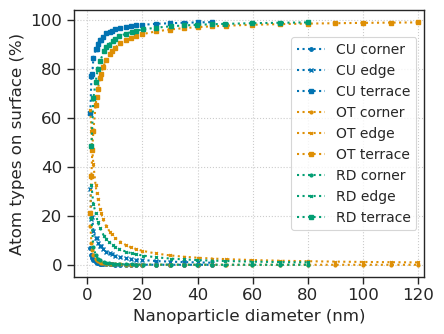

In [6]:
# Percentage of All Surface Atom Types For All Three Shapes in a Plot
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=dpi)
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['corner'], 
        color=sns.color_palette('colorblind')[0], linestyle='dotted', linewidth=1.5, marker='o', markersize=2.5)  #
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['edge'], 
        color=sns.color_palette('colorblind')[0], linestyle='dotted', linewidth=1.5, marker='x', markersize=2.5)
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['terrace'], 
        color=sns.color_palette('colorblind')[0], linestyle='dotted', linewidth=1.5, marker='s', markersize=2.5)

ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['corner'], 
        color=sns.color_palette('colorblind')[1], linestyle='dotted', linewidth=1.5, marker='o', markersize=2)
ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['edge'], 
        color=sns.color_palette('colorblind')[1], linestyle='dotted', linewidth=1.5, marker='x', markersize=2)
ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['terrace'], 
        color=sns.color_palette('colorblind')[1], linestyle='dotted', linewidth=1.5, marker='s', markersize=2.5)

ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['corner'], 
        color=sns.color_palette('colorblind')[2], linestyle='dotted', linewidth=1.5, marker='o', markersize=2)
ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['edge'], 
        color=sns.color_palette('colorblind')[2], linestyle='dotted', linewidth=1.5, marker='x', markersize=2)
ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['terrace'], 
        color=sns.color_palette('colorblind')[2], linestyle='dotted', linewidth=1.5, marker='s', markersize=2.5)

# ax.axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# ax.axhline(96, linestyle='--', color=sns.color_palette('colorblind')[4])
# ax.axhline(97, linestyle='--', color=sns.color_palette('colorblind')[5])
# ax.axhline(98, linestyle='--', color=sns.color_palette('colorblind')[6])
# ax.axhline(99, linestyle='--', color=sns.color_palette('colorblind')[7])
ax.set_xlabel(r'Nanoparticle diameter (nm)')
ax.set_ylabel('Atom types on surface (%)')
ax.set_xlim(right=122)

fig.legend(['CU corner', 'CU edge', 'CU terrace', 'OT corner', 'OT edge', 'OT terrace', 'RD corner', 'RD edge', 'RD terrace'],
           loc='lower left', bbox_to_anchor=(0.65, 0.3), ncol=1)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figures/surfAtomPercAllShapes.png', bbox_inches='tight')

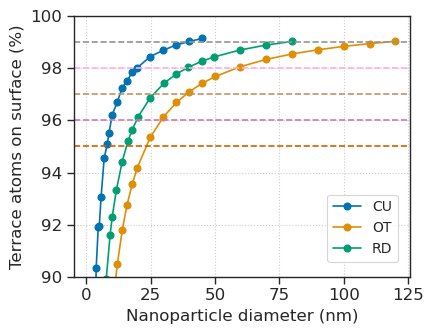

In [7]:
# Zoomed-In Convergence of the Percentage of Terrace Atoms For All Three Shapes
fig, ax = plt.subplots(figsize=(4.5, 3.5), sharey=True, dpi=dpi)
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['terrace'], marker='o')  #, linewidth=3, linestyle='solid',
ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['terrace'], marker='o')
ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['terrace'], marker='o')
ax.axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
ax.axhline(96, linestyle='--', color=sns.color_palette('colorblind')[4])
ax.axhline(97, linestyle='--', color=sns.color_palette('colorblind')[5])
ax.axhline(98, linestyle='--', color=sns.color_palette('colorblind')[6])
ax.axhline(99, linestyle='--', color=sns.color_palette('colorblind')[7])
ax.set_xlabel(r'Nanoparticle diameter (nm)')
ax.set_ylabel('Terrace atoms on surface (%)')
ax.set_ylim(bottom=90, top=100)
fig.legend(['CU', 'OT', 'RD'], loc='lower left', bbox_to_anchor=(0.73, 0.21), ncol=1)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figures/surfTerracePerc.png', bbox_inches='tight')

In [8]:
print('Percentage of terrace atoms for all shapes:')
for shape in ('CU', 'OT', 'RD'):
    print(f"\n{shape}")
    for (i, terracePerc) in enumerate(percSurfAtoms[shape]['terrace']): 
        if terracePerc > 95:
            print(f"{npShapeDiametersDict[shape][i]} Angstrom: {terracePerc:.2f} %")

Percentage of terrace atoms for all shapes:

CU
8.2 Angstrom: 95.09 %
8.9 Angstrom: 95.53 %
10.1 Angstrom: 96.20 %
12.1 Angstrom: 96.71 %
14.0 Angstrom: 97.25 %
15.9 Angstrom: 97.52 %
17.9 Angstrom: 97.84 %
19.8 Angstrom: 98.01 %
24.9 Angstrom: 98.45 %
30.0 Angstrom: 98.69 %
35.0 Angstrom: 98.89 %
40.1 Angstrom: 99.02 %
45.1 Angstrom: 99.14 %

OT
24.9 Angstrom: 95.35 %
30.0 Angstrom: 96.13 %
35.0 Angstrom: 96.69 %
40.1 Angstrom: 97.10 %
45.1 Angstrom: 97.43 %
50.2 Angstrom: 97.68 %
59.9 Angstrom: 98.06 %
70.0 Angstrom: 98.34 %
80.1 Angstrom: 98.55 %
89.9 Angstrom: 98.70 %
100.0 Angstrom: 98.83 %
110.1 Angstrom: 98.94 %
119.8 Angstrom: 99.03 %

RD
16.3 Angstrom: 95.23 %
17.9 Angstrom: 95.64 %
20.2 Angstrom: 96.14 %
24.9 Angstrom: 96.87 %
30.3 Angstrom: 97.43 %
35.0 Angstrom: 97.77 %
39.7 Angstrom: 98.04 %
45.1 Angstrom: 98.27 %
49.8 Angstrom: 98.44 %
59.9 Angstrom: 98.70 %
70.0 Angstrom: 98.89 %
80.1 Angstrom: 99.03 %


The percentages of terrace atoms for `CU`, `OT`, and `RD` are:
- above $95\%$ when the diameters are $8.2$, $24.9$, and $16.3$ nm, respectively.
- above $96\%$ when the diameters are $10.1$, $30.0$, and $20.2$ nm, respectively.
- above $97\%$ when the diameters are $14.0$, $40.1$, and $30.3$ nm, respectively.
- above $98\%$ when the diameters are $19.8$, $59.9$, and $39.7$ nm, respectively. 
- above $99\%$ when the diameters are $45.1$, $119.8$, and $80.1$ nm, respectively. 

### Computing Box-Counting Dimensions for the Large Nanoparticles

Due to the large size of the nanoparticles, the alpha shape algorithm takes a long time to identify the surface atoms. A simpler criterion based on the number of neighbours `numNeigh` is used instead. The parameter values involved are recorded below:
- `findSurfAlg`: `numNeigh`
- `radType`: `atomic`
- `radMult`: $1.2$ for `CU`, $1.1$ for `RD`, either works for `OT`
- `bulkCN`: $14$ for `CU`, $12$ for `RD`, either works for `OT`

In [9]:
facetsDFlist = []
for terracePerc in range(95, 99):
    for surfRep in ('EX', 'VX', 'VXF'):
        with open(f"data/facets{surfRep}{terracePerc}.pickle", 'rb') as f:
            df = pickle.load(f)
        df.dropna(axis=1, inplace=True)
        df.columns = ['DBox', 'lowCI', 'upCI', 'R2', 'minLen', 'maxLen', 'NPname']
        df['surfRep'] = surfRep
        df['terracePerc'] = terracePerc
        df['shape'] = df.apply(lambda f: f['NPname'][-5:-3], axis=1)
        df['rangeLen'] = df.apply(lambda f: f['maxLen'] - f['minLen'], axis=1)
        facetsDFlist.append(df)
facetsDF = pd.concat(facetsDFlist, axis=0)
facetsEXDF = facetsDF[facetsDF['surfRep'] == 'EX']
facetsEXDF.head()

,DBox,lowCI,upCI,R2,minLen,maxLen,NPname,surfRep,terracePerc,shape,rangeLen
Pd82CU_EX,2.327020,2.101026,2.553015,0.988330,-0.530958,0.470647,Pd82CU_EX,EX,95,CU,1.001606
Pd163RD_EX,2.507057,2.327689,2.686425,0.998486,-0.531429,-0.029484,Pd163RD_EX,EX,95,RD,0.501945
Pd249OT_EX,2.309393,2.146091,2.472696,0.996231,-0.532419,0.220236,Pd249OT_EX,EX,95,OT,0.752655
Pd101CU_EX,2.334755,2.106629,2.562882,0.988189,-0.540720,0.470003,Pd101CU_EX,EX,96,CU,1.010724
Pd202RD_EX,2.231528,2.105181,2.357875,0.998339,-0.534517,0.094695,Pd202RD_EX,EX,96,RD,0.629212


The box-counting dimensions obtained from the exact surface representation, ${D_B}_E$ are deemed more useful for this investigation due to the following reasons:
- ${D_B}_E$ has allowed the ordered and disordered metallic nanoparticle surfaces to be distinguished better than ${D_B}_V$ in [previous works](https://doi.org/10.1002/adts.202301227).
- The limitation of the 3D binary image's resolution to $1024 \times 1024 \times 1024$ voxels due to memory constraint makes the voxelised point cloud representation non-ideal when dealing with large nanoparticles, as the nanoscale details would not be captured well.

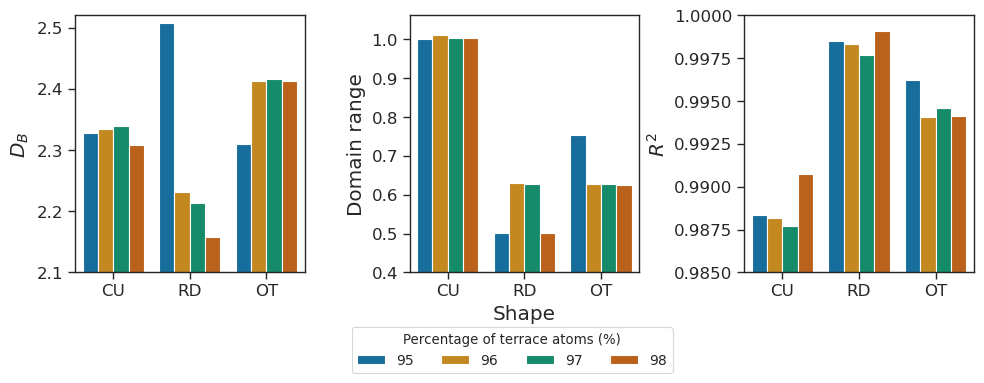

In [10]:
# Differences in Box-Counting Dimension, Domain Range, and Coefficient of Determination as a Function of Shape (Facet Type)
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True, dpi=dpi)
g = sns.barplot(data=facetsEXDF, x='shape', y='DBox', hue='terracePerc', ax=axes[0])
axes[0].set_ylim(bottom=2.1, top=2.52)
axes[0].set_xlabel('', fontsize='large')
axes[0].set_ylabel(r'$D_B$', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=facetsEXDF, x='shape', y='rangeLen', hue='terracePerc', ax=axes[1])
axes[1].set_ylim(bottom=0.4)
axes[1].set_xlabel('Shape', fontsize='large')
axes[1].set_ylabel(r'Domain range', fontsize='large')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=facetsEXDF, x='shape', y='R2', hue='terracePerc', ax=axes[2])
axes[2].set_ylim(bottom=0.985, top=1.00)
axes[2].set_xlabel('')
axes[2].set_ylabel(r'$R^2$', fontsize='large')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Percentage of terrace atoms (%)', loc='lower center', bbox_to_anchor=(0.52, -0.11), ncol=4)
plt.tight_layout()
plt.savefig('figures/facetsDBoxRangeR2.png', bbox_inches='tight')

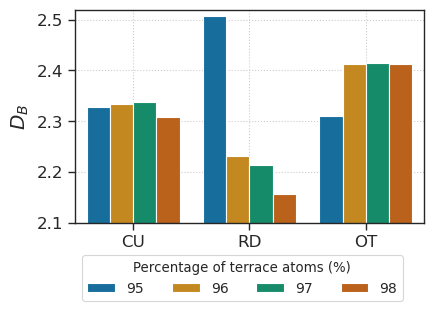

In [11]:
# Differences in Box-Counting Dimension as a Function of Shape (Surface Facet Type)
fig, ax = plt.subplots(figsize=(4.5, 3.5), sharex=True, dpi=dpi)
g = sns.barplot(data=facetsEXDF, x='shape', y='DBox', hue='terracePerc', ax=ax)
plt.ylim(bottom=2.1, top=2.52)
plt.xlabel('', fontsize='large')
plt.ylabel(r'$D_B$', fontsize='large')
plt.legend([],[], frameon=False)
plt.legend(title='Percentage of terrace atoms (%)', loc='lower left', bbox_to_anchor=(0, -0.4), ncol=4, frameon=True)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figures/facetsBCD.png', bbox_inches='tight')

The trend of ${D_B}_E$ values obtained from the palladium nanoparticles with around 95% surface atoms being terrace atoms differs from the other nanoparticle sizes. Greater weight should be placed on the nanoparticles with a larger percentage of surface atoms being terrace because the influence of corner and edge atoms are minimised in these cases. 

The trends observed from the larger palladium nanoparticles (i.e. nanoparticles with 96%, 97%, 98% surface atoms being terrace atoms) indicate that the ${D_B}_E$ values follow the trend of `RD` < `CU` < `OT`, which is equivalent to `{110}` < `{100}` < `{111}`. This implies that the `{111}` facets result in rougher surfaces compared to the `{100}` facets, which is then followed by the `{110}` facets.